## Setting up environment and importing libraries

In this segment, we install the libraries required and set up the environment to train the models. Please choose a GPU runtime in the Google Colab setting. It is also recommended to mount your Google Drive to the notebook so that the static files just need to be downloaded once and can be reused should you need to restart your runtime.

In [1]:
# install required libraries
!pip install transformers timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.7 MB/s eta 0:00:00


In [2]:
import json
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
import pandas as pd

Common configurations to be used throughout the notebook

In [3]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# set random seeds for repeatability
import numpy as np
import random

def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [5]:
seed_val = 0
set_seed(seed_val)

## Data loading and training parameters

This segment downloads the data which we are going to use for the tutorial and defines the paths to read data from, as well as training parameters which we are going to use for all three models.

In [6]:
# HOME_FOLDER = '/content/drive/MyDrive/KDD/' # if mounted
HOME_FOLDER = '/content/KDD/' # if not mounted
WEBVISION_DATA_FOLDER = HOME_FOLDER + 'webvision_data/'
IMAGE_FOLDER = WEBVISION_DATA_FOLDER + 'images/'
RESULTS_FOLDER = HOME_FOLDER + 'results/'
TRAINED_MODELS_FOLDER = HOME_FOLDER + 'trained_models/'
os.makedirs(RESULTS_FOLDER, exist_ok=True)

In [7]:
!mkdir -p $WEBVISION_DATA_FOLDER
!wget "https://drive.google.com/uc?id=1r4aTTbLuYgGrgpZLOgUH9sQ33DBsbOFm&export=download" -O $WEBVISION_DATA_FOLDER/data.zip
!unzip $WEBVISION_DATA_FOLDER/data.zip -d $WEBVISION_DATA_FOLDER

--2023-11-23 01:38:51--  https://drive.google.com/uc?id=1r4aTTbLuYgGrgpZLOgUH9sQ33DBsbOFm&export=download
Resolving drive.google.com (drive.google.com)... 74.125.142.100, 74.125.142.139, 74.125.142.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5phgq4698nqij2o83sq79mlh8d16v2d6/1700703525000/05977284540357373744/*/1r4aTTbLuYgGrgpZLOgUH9sQ33DBsbOFm?e=download&uuid=a20d42cf-9220-413a-8299-dfad5b2be8c5 [following]
--2023-11-23 01:38:58--  https://doc-10-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5phgq4698nqij2o83sq79mlh8d16v2d6/1700703525000/05977284540357373744/*/1r4aTTbLuYgGrgpZLOgUH9sQ33DBsbOFm?e=download&uuid=a20d42cf-9220-413a-8299-dfad5b2be8c5
Resolving doc-10-9c-docs.googleusercontent.com (doc-10-9c-docs.googleusercontent.com)... 74.125.20.132, 2607:f

In [8]:
df_train = pd.read_csv(WEBVISION_DATA_FOLDER + 'train.csv')
df_test = pd.read_csv(WEBVISION_DATA_FOLDER + 'test.csv')

Exceute the cells below to see a random label, text, image triplet from the train dataset

In [9]:
import matplotlib.pyplot as plt

def show_sample(row_num):
    sample_row = df_train.iloc[row_num]
    print('Index:', row_num)
    print('Label:', sample_row['label'])
    print('Text:', sample_row['text'])
    image_path = IMAGE_FOLDER + sample_row['img_path']
    im = Image.open(image_path)
    plt.imshow(im)

Index: 615
Label: confectionery
Text: Smarties Pumpkin Halloween Confectionary


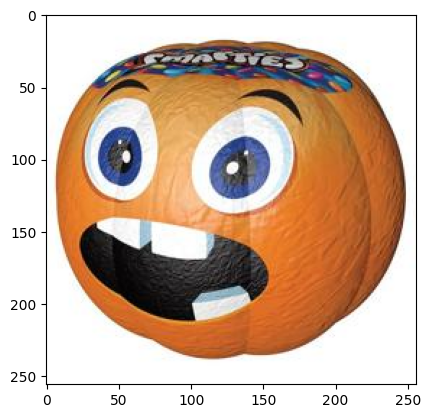

In [105]:
from random import randint
show_sample(randint(511, len(df_train)))

We create the mapping table to map the string labels to integers to be used for the class labels and vice versa.

In [11]:
label_to_id = {lab:i for i, lab in enumerate(df_train['label'].sort_values().unique())}
id_to_label = {v:k for k,v in label_to_id.items()}

In [12]:
label_to_id

{'bookshop': 0,
 'breakwater': 1,
 'chiton': 2,
 'coil': 3,
 'confectionery': 4,
 'gar': 5,
 'gasmask': 6,
 'polecat': 7,
 'seashore': 8,
 'streetcar': 9}

In [13]:
num_out_labels = len(label_to_id)

In [14]:
## training parameters to be used for all models ##
num_train_epochs = 5
batch_size = 16
learning_rate = 1.0e-5
weight_decay = 0.01
warmup_steps = 0
max_seq_length = 64

## BERT
The first model which we are going to train is a BERT model which only uses the text from the data.

### Dataset
Since we are training a text only model, the dataset which we fit into the model only requires two attributes: **text** and **label**.

In [23]:
class TextDataset(Dataset):
    def __init__(self, df, label_to_id, text_field="text", label_field="label"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.text_field = text_field
        self.label_field = label_field

    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]

        return text, label

    def __len__(self):
        return self.df.shape[0]

### Model
The model uses BERT to encode the text, and feeds the encodings (a 768 dimension vector) into a fully connected linear layer with 10 outputs (one for each class label).

![](https://drive.google.com/uc?export=view&id=1nlBu9P8saotjNg_nv_tfdnTxpxaFAhqq)

In [16]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
class VLBertModel(nn.Module):

    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()

        self.num_labels = num_labels
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.classifier = nn.Linear(
            self.text_encoder.config.hidden_size, num_labels)


    def forward(self, text):
        output = self.text_encoder(text.input_ids, attention_mask=text.attention_mask, return_dict=True)
        logits = self.classifier(output.last_hidden_state[:, 0, :]) # CLS embedding
        return logits

In [18]:
# create the model
bert_model = VLBertModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
bert_model = bert_model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Training
Load the data using the text dataset, feed it into a data loader for random sampling, and train the model

In [19]:
set_seed(seed_val)

train_dataset = TextDataset(df=df_train, label_to_id=label_to_id, text_field='text', label_field='label')
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(bert_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

bert_model.train()


start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):
        b_text, b_labels = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )

        b_labels = b_labels.to(device)
        b_inputs = b_inputs.to(device)

        bert_model.zero_grad()
        b_logits = bert_model(text=b_inputs)

        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()

    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])

end = perf_counter()
bert_training_time = end- start
print('Training completed in ', bert_training_time, 'seconds')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 108.78021943569183
    avg_epoch_loss = 2.1756043887138365
    learning rate = 9.045084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 76.00955784320831
    avg_epoch_loss = 1.5201911568641662
    learning rate = 6.545084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 50.48361477255821
    avg_epoch_loss = 1.0096722954511643
    learning rate = 3.4549150281252635e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 41.306292116642
    avg_epoch_loss = 0.8261258423328399
    learning rate = 9.549150281252633e-07


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 38.86050817370415
    avg_epoch_loss = 0.7772101634740829
    learning rate = 0.0
Training completed in  35.456579868000006 seconds


### Testing
Predict on the test set

In [20]:
bert_prediction_results = []

test_dataset = TextDataset(df=df_test, label_to_id=label_to_id, text_field='text', label_field='label')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  bert_model.eval()

  b_text, b_labels = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = bert_model(text=b_inputs)
      b_logits = b_logits.detach().cpu()

  bert_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

bert_prediction_labels = [id_to_label[p] for p in bert_prediction_results]

  0%|          | 0/13 [00:00<?, ?it/s]

Generate the classification report by comparing the predictions from the model with the true labels

In [21]:
bert_class_report = classification_report(df_test['label'], bert_prediction_labels, output_dict=True)
bert_class_report['training_time (seconds)'] = bert_training_time

with open(RESULTS_FOLDER + 'bert_class_report.json', 'w') as f:
  json.dump(bert_class_report, f)

print(bert_class_report['accuracy'])

0.82


In [22]:
# while True:pass

## BERT + ResNet-50
The next model that we are training uses a combination of BERT and ResNet-50 to encode the text and images, respectively.

### Dataset
Unlike the previous Dataset used for BERT, we include images in this dataset by reading the image files and applying a series of transformations to them so that they can fit into the ResNet model.

In [24]:
class ResNetDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field="img_path"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field

        # ResNet-50 settings
        self.img_size = 224
        self.mean, self.std = (
            0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)


        self.train_transform_func = transforms.Compose(
                [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])

        self.eval_transform_func = transforms.Compose(
                [transforms.Resize(256),
                    transforms.CenterCrop(self.img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])


    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        img_path = IMAGE_FOLDER + self.df.at[index, self.image_path_field]


        image = Image.open(img_path)
        if self.train:
          img = self.train_transform_func(image)
        else:
          img = self.eval_transform_func(image)

        return text, label, img

    def __len__(self):
        return self.df.shape[0]

### Model
The original ResNet model consists of a fully connected layer with 1000 classes at the end, to show the scores of each image belonging to that class. However, our output classes are different and we want to use the image features before the fully connected layer instead of the 1000-class output probabilities. Therefore, we "extract" this model out of the original ResNet model architecture by leaving out the fully connected layer.


After that, we pair the extracted ResNet model with a BERT model and add a 10-class linear layer on top of them, like we did for the previous BERT classifier.

![](https://drive.google.com/uc?export=view&id=1vFL3V1LdRlamLjkoI7ieoimxbwGnR7mU)


The ResNet-50 model is trained on imagenet data to classify images into 1000 classes, therefore the last layer is a fully connected layer with 1000 output nodes. This output is not useful to us since our output classes are different. Therefore, we need to strip off this fully connected layer and use the features after the last average pooling layer. This can be done by copying the layers and weights to another network and leave out the last layer.

![](https://drive.google.com/uc?export=view&id=1ivYlubrhvY00P7b2SYLfpRSF3XxJUbfh)

In [25]:
# extract layers of resnet-50 to build a new model

import torch.nn as nn
from torchvision.models.resnet import resnet50

class ResNetFeatureModel(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        pretrained_resnet = resnet50(pretrained=True)
        self.children_list = []
        for n,c in pretrained_resnet.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)


    def forward(self,x):
        x = self.net(x)
        x = torch.flatten(x, 1)
        return x

In [26]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [27]:
# last output layer name for resnet is named 'layer4', dim 2048*7*7
# last layer name before fc is named 'avgpool', dim 2048*1*1 -> needs to be flattened
# reference: https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-c00589bda32b

class BertResNetModel(nn.Module):
    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.visual_encoder = ResNetFeatureModel(output_layer='avgpool')
        self.image_hidden_size = 2048

        self.classifier = nn.Linear(self.text_encoder.config.hidden_size + self.image_hidden_size, num_labels)

    def forward(self, text, image):
        text_output = self.text_encoder(**text)
        text_feature = text_output.last_hidden_state[:, 0, :]
        img_feature = self.visual_encoder(image)
        features = torch.cat((text_feature, img_feature), 1)

        logits = self.classifier(features)

        return logits

In [28]:
resnet_model = BertResNetModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 70.7MB/s]


### Training
Similar to BERT training, but we take in images as an additional input

In [29]:
## training loop
set_seed(seed_val)

train_dataset = ResNetDataset(df=df_train, label_to_id=label_to_id, train=True, text_field='text', label_field='label', image_path_field='img_path')
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

resnet_model.train()

start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):
        b_text, b_labels, b_imgs = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )

        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        resnet_model.zero_grad()
        b_logits = resnet_model(text=b_inputs, image=b_imgs)

        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()

    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])
end = perf_counter()
resnet_training_time = end- start
print('Training completed in ', resnet_training_time, 'seconds')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 106.57896721363068
    avg_epoch_loss = 2.1315793442726134
    learning rate = 9.045084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 76.43772840499878
    avg_epoch_loss = 1.5287545680999757
    learning rate = 6.545084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 55.039288222789764
    avg_epoch_loss = 1.1007857644557952
    learning rate = 3.4549150281252635e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 45.52808743715286
    avg_epoch_loss = 0.9105617487430573
    learning rate = 9.549150281252633e-07


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 42.919267535209656
    avg_epoch_loss = 0.8583853507041931
    learning rate = 0.0
Training completed in  83.10700878299997 seconds


### Testing

In [30]:
# testing loop

resnet_prediction_results = []

test_dataset = ResNetDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  resnet_model.eval()

  b_text, b_labels, b_imgs = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_imgs = b_imgs.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = resnet_model(text=b_inputs, image=b_imgs)
      b_logits = b_logits.detach().cpu()

  resnet_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

resnet_prediction_labels = [id_to_label[p] for p in resnet_prediction_results]

  0%|          | 0/13 [00:00<?, ?it/s]

Generate the classification report

In [31]:
resnet_class_report = classification_report(df_test['label'], resnet_prediction_labels, output_dict=True)
resnet_class_report['training_time (seconds)'] = resnet_training_time

with open(RESULTS_FOLDER + 'resnet_class_report.json', 'w') as f:
  json.dump(resnet_class_report, f)

print(resnet_class_report['accuracy'])

0.795


In [32]:
# while True:pass

## ALBEF
The last model that we are training is the ALBEF joint-encoder model which aligns the text and image features.

### ALBEF-specific setup
This section creates the folder structure and download the necessary files required to train an ALBEF model.

In [33]:
ALBEF_FOLDER = HOME_FOLDER + 'ALBEF/'
os.makedirs(ALBEF_FOLDER, exist_ok=True)

In [34]:
# download pre-trained ALBEF model and required ALBEF files from ALBEF's official repo (only need to do this once to save it in your gdrive)
!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/vit.py -O $ALBEF_FOLDER/vit.py
!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/tokenization_bert.py -O $ALBEF_FOLDER/tokenization_bert.py
!wget https://raw.githubusercontent.com/salesforce/ALBEF/main/models/xbert.py -O $ALBEF_FOLDER/xbert.py


--2023-11-23 01:45:54--  https://raw.githubusercontent.com/salesforce/ALBEF/main/models/vit.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8558 (8.4K) [text/plain]
Saving to: ‘/content/KDD/ALBEF//vit.py’

/content/KDD/ALBEF/ 100%[===================>]   8.36K  --.-KB/s    in 0s      

2023-11-23 01:45:54 (79.4 MB/s) - ‘/content/KDD/ALBEF//vit.py’ saved [8558/8558]

--2023-11-23 01:45:54--  https://raw.githubusercontent.com/salesforce/ALBEF/main/models/tokenization_bert.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24750 (

In [35]:
# replace all occurrences of tokenizer_class with processor_class in xbert.py to make it compatible with newer transformers version
# if you don't do this step, you will need to install transformers==4.8.1 as specified by the requirements in the ALBEF repo

!sed -i 's/tokenizer_class/processor_class/g' $ALBEF_FOLDER/xbert.py

In [36]:
# add path to downloaded ALBEF files
import sys
sys.path.append(ALBEF_FOLDER)

#import libraries required for ALBEF
from vit import VisionTransformer
from xbert import BertConfig as AlbefBertConfig, BertModel as AlbefBertModel
from functools import partial

### Dataset
Same as the BERT-ResNet Dataset which contains **text**, **images** and **labels**. The only difference here is the image size (ResNet - 224, ALBEF - 256).

In [38]:
class AlbefDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field="img_path"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field

        # ALBEF settings
        self.img_size = 256
        self.mean, self.std = (
            0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)


        self.train_transform_func = transforms.Compose(
                [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])

        self.eval_transform_func = transforms.Compose(
                [transforms.Resize(256),
                    transforms.CenterCrop(self.img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])


    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        img_path = IMAGE_FOLDER + self.df.at[index, self.image_path_field]


        image = Image.open(img_path)
        if self.train:
          img = self.train_transform_func(image)
        else:
          img = self.eval_transform_func(image)

        return text, label, img

    def __len__(self):
        return self.df.shape[0]

### Model
ALBEF also uses BERT as its text encoder. Its image encoder is actually a VisionTransformer model.
We use the joint text-image encoder to encode both the text and images, and as with the previous two models, add a linear fully connected layer to it.

![](https://drive.google.com/uc?export=view&id=1zcBBx08_7ujlH2RS2WZrmTZ--Icsk4NN)

In [39]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [40]:
class AlbefModel(nn.Module):

    def __init__(self, bert_config, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()

        self.num_labels = num_labels
        self.text_encoder = AlbefBertModel.from_pretrained(
            text_pretrained, config=bert_config, add_pooling_layer=False)

        self.visual_encoder = VisionTransformer(
            img_size=256, patch_size=16, embed_dim=768, depth=12, num_heads=12,
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

        self.classifier = nn.Linear(
            self.text_encoder.config.hidden_size, num_labels)


    def forward(self, text, image):
        image_embeds = self.visual_encoder(image)
        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(image_embeds.device)
        output = self.text_encoder(text.input_ids, attention_mask=text.attention_mask,
                                   encoder_hidden_states=image_embeds, encoder_attention_mask=image_atts, return_dict=True
                                   )
        logits = self.classifier(output.last_hidden_state[:, 0, :])
        return logits

Because ALBEF aligns the BERT and VisionTransformers features, it has its own BERT configuration. We download both this configuration and the pretrained model from Salesforce's GitHub and web pages in the function below which loads a pretrained model.

In [41]:
from urllib.request import urlretrieve

def load_albef_pretrained(num_out_labels):
    tmp_directory = './tmp/albef'
    os.makedirs(tmp_directory, exist_ok=True)

    albef_bert_config_fp = os.path.join(tmp_directory, 'config_bert.json')
    albef_model_fp = os.path.join(tmp_directory, 'ALBEF.pth')

    if not os.path.exists(albef_bert_config_fp):
        urlretrieve("https://raw.githubusercontent.com/salesforce/ALBEF/main/configs/config_bert.json", albef_bert_config_fp)

    if not os.path.exists(albef_model_fp):
        urlretrieve("https://storage.googleapis.com/sfr-pcl-data-research/ALBEF/ALBEF_4M.pth", albef_model_fp)

    albef_bert_config = AlbefBertConfig.from_json_file(albef_bert_config_fp)
    albef_model = AlbefModel(bert_config=albef_bert_config, num_labels=num_out_labels)

    albef_checkpoint = torch.load(albef_model_fp, map_location='cpu')
    albef_state_dict = albef_checkpoint['model']

    for key in list(albef_state_dict.keys()):
        if 'bert' in key:
            encoder_key = key.replace('bert.', '')
            albef_state_dict[encoder_key] = albef_state_dict[key]
            del albef_state_dict[key]

    msg = albef_model.load_state_dict(albef_state_dict, strict=False)
    print("ALBEF checkpoint loaded from ", albef_model_fp)
    print(msg)
    return albef_model

In [42]:
albef_model = load_albef_pretrained(num_out_labels=num_out_labels)
albef_model = albef_model.to(device)

ALBEF checkpoint loaded from  ./tmp/albef/ALBEF.pth
_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=['temp', 'image_queue', 'text_queue', 'queue_ptr', 'vision_proj.weight', 'vision_proj.bias', 'text_proj.weight', 'text_proj.bias', 'itm_head.weight', 'itm_head.bias', 'visual_encoder_m.cls_token', 'visual_encoder_m.pos_embed', 'visual_encoder_m.patch_embed.proj.weight', 'visual_encoder_m.patch_embed.proj.bias', 'visual_encoder_m.blocks.0.norm1.weight', 'visual_encoder_m.blocks.0.norm1.bias', 'visual_encoder_m.blocks.0.attn.qkv.weight', 'visual_encoder_m.blocks.0.attn.qkv.bias', 'visual_encoder_m.blocks.0.attn.proj.weight', 'visual_encoder_m.blocks.0.attn.proj.bias', 'visual_encoder_m.blocks.0.norm2.weight', 'visual_encoder_m.blocks.0.norm2.bias', 'visual_encoder_m.blocks.0.mlp.fc1.weight', 'visual_encoder_m.blocks.0.mlp.fc1.bias', 'visual_encoder_m.blocks.0.mlp.fc2.weight', 'visual_encoder_m.blocks.0.mlp.fc2.bias', 'visual_encoder_m.blocks.1.norm1

### Training

In [43]:
## training loop
set_seed(seed_val)

train_dataset = AlbefDataset(df=df_train, label_to_id=label_to_id, train=True, text_field='text', label_field='label', image_path_field='img_path')
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(albef_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

albef_model.train()

start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):
        b_text, b_labels, b_imgs = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )

        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        albef_model.zero_grad()
        b_logits = albef_model(text=b_inputs, image=b_imgs)

        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()

    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])
end = perf_counter()
albef_training_time = end- start
print('Training completed in ', albef_training_time, 'seconds')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 104.03732025623322
    avg_epoch_loss = 2.0807464051246645
    learning rate = 9.045084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 69.90639680624008
    avg_epoch_loss = 1.3981279361248016
    learning rate = 6.545084971874738e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 47.07778364419937
    avg_epoch_loss = 0.9415556728839874
    learning rate = 3.4549150281252635e-06


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 37.305219292640686
    avg_epoch_loss = 0.7461043858528137
    learning rate = 9.549150281252633e-07


Batch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 34.76360112428665
    avg_epoch_loss = 0.695272022485733
    learning rate = 0.0
Training completed in  237.399419404 seconds


### Testing

In [46]:
# testing loop

albef_prediction_results = []

test_dataset = AlbefDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  albef_model.eval()

  b_text, b_labels, b_imgs = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_imgs = b_imgs.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = albef_model(text=b_inputs, image=b_imgs)
      b_logits = b_logits.detach().cpu()



  albef_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

albef_prediction_labels = [id_to_label[p] for p in albef_prediction_results]


  0%|          | 0/13 [00:00<?, ?it/s]

Generate the classification report

In [47]:
albef_class_report = classification_report(df_test['label'], albef_prediction_labels, output_dict=True)
albef_class_report['training_time (seconds)'] = albef_training_time

with open(RESULTS_FOLDER + 'albef_class_report.json', 'w') as f:
  json.dump(albef_class_report, f)

print(albef_class_report['accuracy'])


0.81


## Predict on models trained with 20 epochs
In the previous segments, we trained each model for only 5 epochs due to the tutorial's time constraint. Thus, we cannot see a significant contrast between the accuracies of the models. Training for more epochs will improve the models' accuracies. Therefore, we have trained the models for 20 epochs each and saved them. In this segment, we will load the models and make predictions on the test set to compare their accuracies.

The code in the previous segments have to be reused to load the models. Before executing this step, the following cells must have been executed:
- Setup and common config cells
- ALBEF-specific cells
- ALBEF-loading cells
- Cells containing model code for BERT, BERT-ResNet and ALBEF


In [48]:
# Download trained_models.zip file to trained_models folder
!wget "https://drive.google.com/u/0/uc?id=1MGaKK4nHTd4FWDnvFihb6b8lASjeuN_l&export=download&confirm=t" -O $HOME_FOLDER/trained_models.zip
!unzip $HOME_FOLDER/trained_models.zip -d $HOME_FOLDER

--2023-11-23 01:56:00--  https://drive.google.com/u/0/uc?id=1MGaKK4nHTd4FWDnvFihb6b8lASjeuN_l&export=download&confirm=t
Resolving drive.google.com (drive.google.com)... 142.250.99.102, 142.250.99.138, 142.250.99.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.99.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1MGaKK4nHTd4FWDnvFihb6b8lASjeuN_l&export=download&confirm=t [following]
--2023-11-23 01:56:00--  https://drive.google.com/uc?id=1MGaKK4nHTd4FWDnvFihb6b8lASjeuN_l&export=download&confirm=t
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ep0e6dlv0r1b7pf78dessq5kc1ncic0f/1700704500000/05977284540357373744/*/1MGaKK4nHTd4FWDnvFihb6b8lASjeuN_l?e=download&uuid=b1ca49cc-88fd-4892-8a53-090978fc62d9 [following]
--2023-11-23 01:56:00--  https://doc-1

This function loads the pretrained model for each of the three model architectures.

In [59]:
def load_trained_models(load_directory, image_model_type):
    label_map_filepath = os.path.join(load_directory, "label_map.json")
    with open(label_map_filepath, 'r') as f:
        label_to_id = json.load(f)

    id_to_label = {v: k for k, v in label_to_id.items()}

    num_labels = len(label_to_id)

    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    model_sd_filepath = os.path.join(load_directory, "state_dict.pt")
    model_sd = torch.load(model_sd_filepath, map_location='cpu')

    if image_model_type is None:
        model = VLBertModel(num_labels=num_labels)
    elif image_model_type.lower() == 'resnet':
        model = BertResNetModel(num_labels=num_labels)
    elif image_model_type.lower() == 'albef':
        model = load_albef_pretrained(num_out_labels=num_labels)

    # Filter out unexpected keys
    unexpected_keys = [k for k in model_sd.keys() if k not in model.state_dict()]
    for key in unexpected_keys:
        del model_sd[key]

    model.to('cpu')  # Load all models on CPU first
    model.load_state_dict(model_sd, strict=True)
    model.to(device)

    return model, tokenizer, label_to_id, id_to_label


We streamline the three different datasets presented previously into one common VLDataset class which has **text**, **images** and **labels**.

In [60]:
class VLDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field=None, image_model_type=None):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field
        self.image_model_type = image_model_type

        # text only dataset
        if image_model_type is not None:

            # ResNet-50 and ALBEF use different image sizes
            if image_model_type.lower() == "resnet":   # ResNet-50 settings
                self.img_size = 224
            elif image_model_type.lower() == "albef":   # ALBEF settings
                self.img_size = 256

            self.mean, self.std = (
                0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)


            self.train_transform_func = transforms.Compose(
                    [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(self.mean, self.std)
                        ])

            self.eval_transform_func = transforms.Compose(
                    [transforms.Resize(256),
                        transforms.CenterCrop(self.img_size),
                        transforms.ToTensor(),
                        transforms.Normalize(self.mean, self.std)
                        ])



    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]

        # return images only if image model is specified
        if self.image_model_type is not None:
            img_path = IMAGE_FOLDER + self.df.at[index, self.image_path_field]


            image = Image.open(img_path)
            if self.train:
                img = self.train_transform_func(image)
            else:
                img = self.eval_transform_func(image)

            return text, label, img

        else:
            return text, label

    def __len__(self):
        return self.df.shape[0]

We also streamline the predict function to do prediction on the test set with the loaded models of any of the three model architectures.

In [61]:
## testing loop
def predict(df_test, model, tokenizer, label_to_id, id_to_label, image_model_type):
    prediction_results = []

    test_dataset = VLDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path', image_model_type=image_model_type)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                sampler=test_sampler)


    for batch in tqdm(test_dataloader):
        model.eval()

        if image_model_type is None:
          b_text, b_labels = batch
          b_imgs = None
        else:
          b_text, b_labels, b_imgs = batch

        b_inputs = tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

        b_labels = b_labels.to(device)
        b_inputs = b_inputs.to(device)

        if b_imgs is not None:
          b_imgs = b_imgs.to(device)

        with torch.no_grad():
            if b_imgs is not None:
              b_logits = model(text=b_inputs, image=b_imgs)
            else:
              b_logits = model(text=b_inputs)

            b_logits = b_logits.detach().cpu()



        prediction_results += torch.argmax(b_logits, dim=-1).tolist()

    prediction_labels = [id_to_label[p] for p in prediction_results]

    print(accuracy_score(df_test['label'], prediction_labels))

    return prediction_labels

### Predict with loaded BERT model

In [62]:
bert_load_directory = TRAINED_MODELS_FOLDER + 'BERT'
bert_model, bert_tokenizer, label_to_id, id_to_label = load_trained_models(bert_load_directory, image_model_type=None)
bert_predictions = predict(df_test.copy(), bert_model, bert_tokenizer, label_to_id, id_to_label, image_model_type=None)

  0%|          | 0/13 [00:00<?, ?it/s]

0.92


### Predict with loaded BERT-ResNet model

In [63]:
bert_resnet_load_directory = TRAINED_MODELS_FOLDER + 'BERT_ResNet'
bert_resnet_model, bert_resnet_tokenizer, label_to_id, id_to_label = load_trained_models(bert_resnet_load_directory, image_model_type='resnet')
bert_resnet_predictions = predict(df_test.copy(), bert_resnet_model, bert_resnet_tokenizer, label_to_id, id_to_label, image_model_type='resnet')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?it/s]

0.93


### Predict with loaded ALBEF model

In [64]:
albef_load_directory = TRAINED_MODELS_FOLDER + 'ALBEF'
albef_model, albef_tokenizer, label_to_id, id_to_label = load_trained_models(albef_load_directory, image_model_type='albef')
albef_predictions = predict(df_test.copy(), albef_model, albef_tokenizer, label_to_id, id_to_label, image_model_type='albef')

ALBEF checkpoint loaded from  ./tmp/albef/ALBEF.pth
_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=['temp', 'image_queue', 'text_queue', 'queue_ptr', 'vision_proj.weight', 'vision_proj.bias', 'text_proj.weight', 'text_proj.bias', 'itm_head.weight', 'itm_head.bias', 'visual_encoder_m.cls_token', 'visual_encoder_m.pos_embed', 'visual_encoder_m.patch_embed.proj.weight', 'visual_encoder_m.patch_embed.proj.bias', 'visual_encoder_m.blocks.0.norm1.weight', 'visual_encoder_m.blocks.0.norm1.bias', 'visual_encoder_m.blocks.0.attn.qkv.weight', 'visual_encoder_m.blocks.0.attn.qkv.bias', 'visual_encoder_m.blocks.0.attn.proj.weight', 'visual_encoder_m.blocks.0.attn.proj.bias', 'visual_encoder_m.blocks.0.norm2.weight', 'visual_encoder_m.blocks.0.norm2.bias', 'visual_encoder_m.blocks.0.mlp.fc1.weight', 'visual_encoder_m.blocks.0.mlp.fc1.bias', 'visual_encoder_m.blocks.0.mlp.fc2.weight', 'visual_encoder_m.blocks.0.mlp.fc2.bias', 'visual_encoder_m.blocks.1.norm1

  0%|          | 0/13 [00:00<?, ?it/s]

0.97


### Save predictions

In [65]:
df_out = df_test.copy()
df_out['bert_predictions'] = bert_predictions
df_out['bert_resnet_predictions'] = bert_resnet_predictions
df_out['albef_predictions'] = albef_predictions
df_out.to_csv(RESULTS_FOLDER + 'predictions_with_pretrained_models.csv', index=False)


In [106]:
pip install pandas

In [110]:
import pandas as pd

# Replace 'path/to/train.csv' with the actual path to your CSV file
csv_file_path = '/content/KDD/webvision_data/train.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df.head(4))


                                                text            img_path  \
0     Learn more at pavloposadskie-platki.ru. &quot;  2FDs4TjBq3GmAM.jpg   
1                Relief Map of the Mediterranean Sea  LfzSYqSPSyoROM.jpg   
2  NumisBids: Heritage World Coin Auctions Long B...  K-VGDhf89E-PWM.jpg   
3                     Learn more at img.thesun.co.uk  jvSFSOvgKDTJaM.jpg   

    label  
0  chiton  
1  chiton  
2  chiton  
3  chiton  
